In [26]:
#!pip install nltk
#!pip install moviepy
import os 
import time
import json
import nltk
nltk.download('punkt')
import string
import pickle
import datetime
import pickle
import pandas as pd
from os import listdir
import re
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt



[nltk_data] Downloading package punkt to /home/reboud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as xml

In [15]:
from moviepy.editor import *
from tqdm.notebook import tqdm
from collections import Counter

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

strptime = datetime.datetime.strptime

In [16]:
mentions_path = 'coref/summaries_mentions.pickle'
mentions = pickle.load(open(mentions_path, 'rb'))
print('support', mentions['s01e07']['support'][:2], '..')
print('marked', mentions['s01e07']['marked'][:2], '..')
print('characters', mentions['s01e07']['characters'][:2], '..')


support ['Synopsis When four members of a family are brutally murdered in a suburban house, except the two daughters who are the sole survivors, the nightshift is called', 'At first, Gil Grissom and his entire team suspect a bizarre cult murder, but the evidence tells an even more disturbing story, when they discover the motive behind the massacre'] ..
marked ['Synopsis When four members of a family are brutally murdered in a suburban house , except the two daughters who are the sole survivors , the nightshift is called', 'At first , Gil #Grissom and his entire team suspect a bizarre cult murder , but the evidence tells an even more disturbing story , when they discover the motive behind the massacre'] ..
characters [[], ['Grissom']] ..


In [17]:
path_screenplays_scenes='coref/csi-corpus/screenplay_summarization/scene_level_n_aspects'
all_chars = []
ep_characters = {}

eps=[]

for ep in listdir(path_screenplays_scenes):
    #print(ep)
    annotated_scenes=pd.read_csv(path_screenplays_scenes+'/'+ep)
    eps.append(ep.split('.csv')[0])
    




In [6]:
print(eps)
print(eps[-7])



['s05e10', 's03e03', 's01e19', 's01e23', 's02e15', 's02e01', 's05e22', 's02e09', 's05e21', 's04e23', 's04e09', 's05e12', 's03e12', 's05e03', 's04e22', 's03e21', 's02e04', 's03e19', 's04e14', 's04e06', 's01e07', 's04e21', 's05e17', 's03e08', 's04e10', 's04e05', 's05e05', 's05e06', 's01e20', 's04e15', 's02e06', 's01e08', 's04e12', 's05e08', 's03e05', 's02e10', 's05e13', 's03e11', 's01e13']
s04e12


In [7]:
df=pd.DataFrame()

print('yo')

yo


In [18]:
ps = PorterStemmer()
ls = LancasterStemmer()
do_stem = True


In [14]:
ps.stem('kills')

'kill'

In [19]:
def compute_similarity(content, summary_line, method):
    if method[0] == 'tfidf':
        weights = method[1]
        return sum(weights[w] if w in weights else 0 for w in set(content.split()) if w in summary_line.split())
    if method[0] == 'tfidf_log':
        weights = method[1]
        dn = np.log(len(content.split() + summary_line.split()) + 1) if len(content.strip().split()) > 0 else 1
        return sum(weights[w] if w in weights else 0 for w in set(content.split()) if w in summary_line.split())/dn
    if method[0] == 'tfidf_log_2':
        weights = method[1]
        n = sum(1 if w in weights else 0 for w in set(content.split()) if w in summary_line.split())
        dn = np.log(len(content.split() + summary_line.split()) - n + 1) 
        dn = dn if dn > 0 else 1
        return sum(weights[w] if w in weights else 0 for w in set(content.split()) if w in summary_line.split())/dn
    if method[0] == 'tfidf_log_3':
        weights = method[1]
        n = sum(1 if w in weights else 0 for w in set(content.split()) if w in summary_line.split())
        dn = np.log10(len(content.split() + summary_line.split()) - n + 1) 
        dn = dn if dn > 0 else 1
        return sum(weights[w] if w in weights else 0 for w in set(content.split()) if w in summary_line.split())/dn
    if method[0] == 'tfidf_sqrt':
        weights = method[1]
        n = sum(1 if w in weights else 0 for w in set(content.split()) if w in summary_line.split())
        dn = np.sqrt(len(content.split() + summary_line.split()) - n + 1) 
        dn = dn if dn > 0 else 1
        return sum(weights[w] if w in weights else 0 for w in set(content.split()) if w in summary_line.split())/dn
    elif method[0] == 'count':
        return len([w for w in set(content.split()) if w in summary_line.split()])
    elif method[0] == 'count_2':
        dn = np.log(len(content.split() + summary_line.split()) + 1) 
        dn = dn if dn > 0 else 1
        return len([w for w in set(content.split()) if w in summary_line.split()]) / dn

In [34]:
f1_scores=[]
len_summary=[]

#eps=['s02e04']


#eps=['s03e12', 's05e13', 's01e20', 's05e10', 's01e08', 's04e14', 's05e22', 's03e19', 's04e23', 's05e21', 's02e06', 's04e10', 's05e08', 's03e05', 's04e22', 's05e06', 's01e13', 's02e01', 's05e17', 's01e07', 's04e21', 's05e12', 's02e15', 's04e12', 's03e03', 's04e05', 's02e10', 's02e09', 's05e05', 's05e03', 's04e15', 's01e23', 's03e21', 's04e06', 's03e08', 's01e19']

for ep in eps:
    print(ep)
    annotated_scenes=pd.read_csv(path_screenplays_scenes+'/'+ep+'.csv')
    nb_positive=len(annotated_scenes[annotated_scenes['in_summary'] == 1])
    vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
    corpus = [' '.join(ps.stem(w) for w in word_tokenize(s) if w.lower() not in vectorizer.get_stop_words()) if do_stem else s for s in annotated_scenes['scene_text'].values]
    corpus = [s.translate(str.maketrans('', '', string.punctuation)).replace('  ', ' ').lower() for s in corpus]
    #print(len(corpus))
    #print(len(summaries))
    vectorizer.fit(corpus)
    corpus_tf_idf = vectorizer.transform(corpus)
    word_count = Counter([w for s in corpus for w in s.split()])
    ', '.join(sorted(vectorizer.get_stop_words()))
    tfidf_weights = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    method_used=('tfidf',tfidf_weights)
    summaries_raw = [s for s in mentions[ep]['marked']]
    print(summaries_raw)
    len_summary.append(len(summaries_raw))
    summaries = [' '.join(ps.stem(w) for w in word_tokenize(s) if w.lower() not in vectorizer.get_stop_words()) if do_stem else s for s in summaries_raw]
    summaries = [s.translate(str.maketrans('', '', string.punctuation)).replace('  ', ' ') for s in summaries]
    similarity_matrix = np.zeros((len(corpus), len(summaries)))
    for i, content in tqdm(enumerate(corpus), total=len(corpus)):
        for j, s in enumerate(summaries):
            #print(i)
            #print(j)
            similarity_matrix[i, j] = compute_similarity(content, s, method=method_used)
    unrolled_sm = [(similarity_matrix[i, j], i, j)  for i in range(len(corpus)) for j in range(len(summaries))]
    best_matches = sorted(unrolled_sm, key=lambda x: -x[0])
    score = {}
    #print(j, summaries_raw[j])
    for (v, scene, syn) in best_matches:
        if scene not in score : score[scene] = []
        score[scene].append(v)
        #print(score[scene])
        
        
    for scene in score:
        score[scene] = sum(score[scene])

    #print(score.items())    
    reses = sorted(score.items(), key=lambda x: -x[1])
 
    scenes=[i[0] for i in reses[0:nb_positive]]
    #sim_score=[i[1] for i in reses]
    sim_score=pd.DataFrame(data=reses,columns=['scene_id','prediction_score'])
    print(sim_score)
    
    
    
    #print(scenes)


    #print(syn, summaries_raw[syn])
    
    #annotated_scenes['prediction_score']=sim_score
    #annotated_scenes['prediction_score'] = annotated_scenes['scene_id'].apply(lambda x: sim_score[i] if x in scenes[i] for i range(len(scenes)) else 0)
    
    
    
    annotated_scenes = pd.merge(annotated_scenes, sim_score, on='scene_id')
    
    annotated_scenes['prediction'] = annotated_scenes['scene_id'].apply(lambda x: 1 if x in scenes else 0)
    #annotated_scenes['synopses'] = annotated_scenes['prediction'].apply(lambda x: summaries_raw[syn]  if x==1 else 0)
    annotated_scenes['aspect?'] = annotated_scenes['aspects'].apply(lambda x: 0 if x == 'None' else 1)
    print(method_used[0])
    #annotated_scenes.to_csv(ep+'_'+method_onused[0]+'_similarity.csv')
    
    #print('Episode')
    #print(ep)
    print(f1_score(annotated_scenes.in_summary, annotated_scenes.prediction))
    f1_scores.append(f1_score(annotated_scenes.in_summary, annotated_scenes.prediction))
    
    

s05e10
['Synopsis After a gang shooting , #Grissom and #Grissom team work on a case of a young boy found dead in a dumpster while #Catherine and #Catherine team try to find out why an prisoner was left brain dead after an action by police', 'Plot Victim : Devon Malton ( deceased )   On the case : Gil #Grissom , #Greg Sanders , #Sara Sidle , Sofia #Curtis , Jim #Brass   While investigating an apparent gang shooting , #Greg hears some kids playing nearby and it seems like they are reenacting the shooting', 'When #Greg goes to talk to them , they run away quickly', 'One of boys trips over a trash bin and #Greg notices that there is the body of a young boy in it', '#Greg radios #Grissom to tell #Greg #Greg finding', "Back near the original body , someone comes up and shoots the victim 's brother in the back several times", 'The shooter runs and both the cops and ~Sofia chase after him', 'The crime scene has just become a triple homicide', '#Sara arrives on the scene to assist #Greg while D


    scene_id  prediction_score
0          0        693.108264
1         29        652.123571
2         18        644.155980
3          1        580.108289
4          2        573.002095
5          7        565.668978
6         16        557.279980
7         26        522.396458
8          9        461.897042
9          6        460.301472
10        25        418.667271
11        11        388.936604
12         4        381.019036
13        20        377.497841
14        14        375.736430
15        17        364.134914
16        10        338.864776
17        33        335.865843
18        31        332.400326
19        19        329.699041
20         8        323.285373
21        13        316.238108
22        28        310.325775
23         3        307.438174
24        21        304.482706
25         5        287.393872
26        27        271.153308
27        30        211.844727
28        15        211.411865
29        32        205.440410
30        24        174.369933
31     


    scene_id  prediction_score
0          9        519.176088
1         26        486.495635
2         22        449.297496
3         36        439.755004
4         34        380.515470
5         17        367.577388
6         18        364.129744
7          4        345.619451
8         24        295.416701
9         14        292.149733
10        20        281.715173
11        29        277.430241
12        21        276.443685
13        30        271.705572
14        13        266.909498
15        37        256.936965
16        28        247.743590
17        15        243.925760
18         7        242.130966
19        23        222.673950
20        38        194.271325
21         5        185.882310
22         6        183.189506
23        12        178.621291
24        19        175.105690
25        16        166.091977
26        25        164.012436
27        11        162.821734
28        27        157.960219
29        35        140.866422
30        32        139.030049
31     


    scene_id  prediction_score
0         31        391.960208
1         23        272.806015
2         33        252.587928
3          4        238.497692
4         27        228.560068
5         28        214.228672
6         22        206.529117
7         18        199.130796
8          5        176.949217
9         16        175.764793
10        30        166.675879
11        17        166.085082
12        24        155.804431
13         3        146.796715
14        25        146.127633
15        15        142.832845
16        21        140.702186
17        12        136.425396
18        11        124.862081
19        14        121.826591
20        34        119.312442
21        20        115.990349
22         1        102.858497
23        29         98.247558
24         0         95.089046
25        19         89.987700
26        26         89.479501
27         7         88.244771
28        35         83.158816
29        10         79.525389
30        32         79.438061
31     


    scene_id  prediction_score
0         13        367.162552
1          7        330.602595
2         27        316.986621
3         38        273.042907
4         39        259.893646
5          8        253.425077
6         34        253.171857
7         25        246.945332
8         31        234.120842
9         33        227.802898
10        12        209.644683
11         6        206.375690
12         4        180.660529
13        21        180.339710
14        16        177.239984
15        14        166.217676
16        26        164.082158
17        30        156.170092
18        35        153.582677
19        22        149.127125
20        18        140.466995
21        32        140.220173
22        37        124.361999
23        28        109.597548
24        29        105.229238
25        17        103.008903
26        11         92.809238
27        20         84.123068
28        36         82.606018
29         5         77.948637
30         9         73.882447
31     


    scene_id  prediction_score
0         36        345.683412
1         20        248.403758
2         13        246.570593
3         44        243.610324
4          6        240.214002
5         19        239.784966
6         14        238.802209
7         24        233.746432
8         43        226.211168
9         39        195.085967
10        46        189.435735
11        30        185.765939
12         5        170.965440
13        29        168.356863
14        17        167.091238
15        18        163.233129
16         8        157.960247
17         7        153.249860
18         4        149.383476
19        16        146.585134
20        38        144.519096
21        45        131.077755
22        11        123.553839
23        32        123.021720
24        33        118.862355
25        34        108.821696
26        25        107.174186
27        35        100.180855
28        22         94.413071
29        31         92.334657
30        37         92.008008
31     


    scene_id  prediction_score
0         34        703.349233
1         17        601.060985
2         36        585.566644
3         20        556.402756
4         10        551.508311
5         28        517.540857
6         21        495.378488
7          3        486.052471
8         23        480.153079
9         35        448.816045
10        32        447.588283
11        39        446.802862
12         1        441.621279
13        31        440.621887
14        16        406.935995
15         8        364.693349
16        19        353.533975
17         4        353.415682
18        27        347.059639
19         2        335.276353
20        38        333.377027
21        40        322.711852
22        37        308.339471
23        13        300.273796
24        33        279.345147
25        12        267.172787
26         6        247.444381
27         5        243.559579
28        18        213.287243
29        15        213.260691
30        26        169.005285
31     


    scene_id  prediction_score
0         15        971.404095
1         26        909.337641
2         21        757.668288
3          4        714.010835
4         17        641.178875
5         19        570.994153
6         20        567.181524
7         25        563.832494
8         29        555.743312
9         12        547.219585
10        28        535.865179
11        13        486.932461
12        14        479.459280
13        22        437.803811
14         5        427.547938
15         8        423.751694
16         1        419.780736
17        10        396.385220
18         9        389.409455
19        31        385.239599
20        23        372.061369
21        27        366.155074
22         6        355.612486
23        16        354.334698
24        11        335.695377
25        24        331.302521
26         0        310.465503
27        30        301.001914
28         2        276.376145
29         7        263.695214
30         3        215.106824
31     


    scene_id  prediction_score
0         34        628.673586
1         28        618.403744
2         31        548.456035
3         21        524.237073
4         22        508.678965
5         29        450.232962
6          6        434.793251
7         32        427.953131
8         27        425.548380
9         13        333.442369
10        33        327.134932
11        19        319.252940
12         8        317.620451
13        26        303.370141
14        12        298.226993
15        23        290.820519
16        14        284.677335
17         7        263.592693
18        11        232.193154
19        20        230.699997
20        24        226.637963
21        30        198.256124
22         9        192.638806
23        15        190.704042
24         4        179.659466
25        16        178.699645
26        17        168.116149
27         5        154.210201
28        25        150.327080
29         1        148.362743
30         0        147.769470
31     


    scene_id  prediction_score
0         28        804.733193
1          0        801.583203
2          1        712.585007
3         32        646.818290
4         22        629.356395
5         36        612.340298
6         24        554.453327
7         15        530.173158
8         20        519.714604
9         29        512.443571
10        31        494.925518
11        25        494.351981
12        23        483.469957
13        11        449.411559
14         2        441.829625
15        21        414.400937
16         4        409.516720
17        33        391.720756
18        30        390.551287
19        12        377.352783
20        17        325.362825
21         5        313.077828
22        10        299.828012
23         8        298.413944
24        26        267.116998
25         6        256.994960
26        19        245.564152
27        16        237.379654
28        34        233.432305
29        27        233.413183
30        13        210.842801
31     


    scene_id  prediction_score
0         40        500.074920
1         44        476.826284
2         38        473.162208
3         31        455.215499
4         17        401.500428
5         29        399.910624
6         12        365.564772
7         22        341.691494
8         41        336.997101
9         30        330.872589
10        39        318.544221
11         8        311.524921
12        14        305.217013
13         7        284.570172
14        16        275.103451
15         9        270.322121
16        43        265.250267
17        32        260.507012
18         4        257.281499
19        19        246.411065
20        15        236.818924
21        20        234.774684
22        11        226.820652
23        13        225.657378
24        34        225.045252
25        24        221.258271
26         5        214.255395
27        42        193.745134
28         6        185.210449
29        27        184.109173
30        47        168.588748
31     


    scene_id  prediction_score
0          3        593.603034
1         30        590.679969
2          9        561.783106
3         26        555.969691
4         25        543.967037
5         17        521.046079
6          2        512.973388
7         15        490.877407
8         29        446.141288
9         10        421.386039
10         5        403.217524
11        13        376.911796
12        11        366.606165
13         8        360.236156
14         4        345.987693
15        19        340.795744
16        12        337.383486
17        21        327.067479
18         1        321.588511
19        22        310.947581
20        18        294.629857
21        20        285.702164
22         0        285.266214
23        24        276.062764
24        23        272.137835
25         7        241.716243
26        28        234.204023
27        14        229.629062
28         6        214.987847
29        27        137.005021
30        16         57.133134
tfidf
0


    scene_id  prediction_score
0          7        579.883464
1         14        536.184641
2         25        535.017978
3         16        530.304866
4         27        490.023147
5         22        488.810006
6          8        477.298618
7         20        473.824025
8         11        453.886412
9         31        450.423190
10        24        450.241111
11        23        412.238750
12        21        395.651006
13        17        389.355646
14        19        360.503254
15         9        343.269106
16        28        332.124345
17         3        303.373399
18        30        299.951482
19         2        290.485006
20        13        288.875701
21         1        277.590690
22        15        274.816806
23        26        268.121416
24         6        246.455166
25         5        222.712397
26        29        205.405865
27        12        169.499779
28         4        125.766581
29         0        121.827381
30        18         72.148010
31     


    scene_id  prediction_score
0         47        880.149997
1         43        662.148353
2         18        653.299040
3         24        609.784240
4          7        565.409263
5         44        556.608715
6         41        553.643403
7         16        533.290911
8         38        520.750222
9         23        512.085265
10        33        494.307282
11        46        476.896173
12        15        465.498896
13        26        428.662545
14        35        425.816816
15         8        420.733874
16        42        420.663986
17        37        415.195921
18        40        389.157037
19         5        387.759218
20        17        385.942779
21        11        346.597818
22        34        345.585793
23        10        342.826286
24        39        337.388999
25         9        321.518754
26         6        314.515138
27        14        298.097365
28        21        295.589470
29        12        292.483740
30        20        284.534091
31     


    scene_id  prediction_score
0          2        938.094827
1          6        845.341530
2          1        819.112582
3         29        798.902454
4         31        772.768290
5         12        720.295086
6         27        695.161594
7         17        645.307785
8         21        635.408768
9         14        611.704343
10         8        610.671826
11         7        568.867501
12        18        567.004446
13        19        551.707244
14         5        495.887087
15        30        470.327435
16        15        426.951784
17         9        417.458956
18        13        403.768609
19        22        396.917185
20        11        395.047802
21         0        390.643912
22        24        358.775299
23        26        325.279832
24        16        309.652592
25         4        307.347557
26        28        297.066138
27         3        270.023516
28        25        247.112307
29        23        244.556123
30        20        173.184110
31     


    scene_id  prediction_score
0         31       1080.627239
1         17        925.391629
2          2        916.187581
3         21        876.801592
4         33        860.929488
5         15        832.057966
6         27        777.844883
7         29        699.140643
8         25        634.785659
9         23        626.176588
10         5        613.803233
11         9        610.499446
12         8        597.319632
13         6        549.649764
14         4        511.794112
15        26        474.758372
16        12        473.248452
17        18        460.253961
18        19        454.719597
19        10        443.931348
20         1        437.902074
21        20        400.843698
22        30        389.189727
23        16        376.929360
24         3        349.446821
25        32        319.413381
26        14        286.796690
27        28        280.704733
28        24        267.800104
29        34        264.822370
30        13        248.813505
31     


    scene_id  prediction_score
0         42        787.318799
1         21        763.613519
2         18        761.777256
3         22        740.421130
4          6        710.436915
5         40        707.265331
6         19        696.055921
7         37        683.772887
8         38        651.689518
9         39        618.280003
10        30        614.279937
11        28        569.098241
12        25        562.640282
13        11        549.649578
14         3        546.335129
15        27        545.772857
16        13        533.344067
17        29        527.613301
18        17        513.661077
19         4        496.345530
20        16        489.613302
21        24        480.738001
22        31        462.177110
23         9        453.421910
24         8        447.850546
25        10        418.256647
26        26        416.273621
27        23        346.382070
28        14        339.719229
29         1        325.448921
30        15        314.754511
31     


    scene_id  prediction_score
0         39       1282.792013
1         24        869.478157
2         40        774.024731
3         31        733.962473
4         36        677.621708
5          6        676.841727
6         10        676.233751
7         30        656.261605
8         12        573.100356
9         23        542.774428
10        33        527.487435
11         8        497.651782
12         4        493.074075
13        17        473.912073
14        11        448.532919
15         7        438.862479
16        29        434.150939
17        18        413.431359
18         3        389.756042
19        19        385.975486
20        13        383.237409
21        14        364.881952
22        37        361.573720
23         2        353.920243
24        35        352.264632
25         0        349.613696
26        20        348.606966
27         9        346.654067
28        28        321.819901
29        38        307.071872
30        34        306.486160
31     


    scene_id  prediction_score
0         42       1267.188739
1         31       1029.960656
2         26        826.257296
3         41        754.528013
4         34        751.618334
5          3        702.096574
6          2        700.030890
7         12        679.370345
8         23        637.067471
9         25        635.121067
10        18        624.051953
11         5        595.861036
12         4        558.641352
13        30        557.185944
14        14        545.171262
15        21        541.365113
16        15        538.139563
17        13        503.755291
18        29        489.724999
19        33        473.048229
20         9        463.533098
21        28        434.546639
22        10        422.012762
23        16        421.561702
24        32        397.346467
25        11        394.679480
26        19        391.754388
27        20        385.903390
28        43        378.528752
29        17        332.999138
30         6        324.274182
31     


    scene_id  prediction_score
0          2        791.410281
1         37        693.107555
2          3        661.653137
3         28        541.612304
4         29        511.195504
5         42        486.180002
6         21        479.011687
7         17        472.692069
8          1        472.069840
9         36        470.518308
10        34        463.026395
11        19        460.148531
12        25        459.839170
13        22        455.643860
14        26        439.875098
15        16        426.911971
16        31        425.885834
17        40        417.968076
18        39        398.976556
19        11        381.531960
20         0        348.023969
21        12        322.410306
22        15        315.900017
23         6        303.130866
24        27        301.897888
25         5        301.216314
26        18        295.548703
27        30        283.994412
28        13        271.632855
29        43        268.744461
30        41        266.999200
31     


    scene_id  prediction_score
0         32        598.173303
1         11        577.658934
2         27        489.331437
3         25        485.512309
4         22        480.137814
5         36        476.559429
6         31        467.074317
7         26        465.606061
8         33        459.053583
9          3        435.874242
10        17        429.197117
11        10        375.762403
12         7        364.864390
13        18        358.324334
14        24        351.234533
15        12        336.725677
16        15        328.669186
17        34        322.469362
18         9        317.062061
19         1        311.300608
20        21        309.165288
21        35        294.496068
22         8        282.981718
23         0        282.219273
24        23        277.807885
25        19        250.484861
26        14        235.076448
27        20        225.199807
28        28        187.970324
29         6        168.563811
30        13        165.462243
31     


    scene_id  prediction_score
0         43        371.845697
1         47        301.832381
2         29        260.072900
3         18        240.257313
4         14        236.344373
5         34        202.354676
6         45        190.010151
7         24        182.032139
8         37        179.889073
9         30        168.444679
10        28        151.637133
11        20        134.867726
12        10        134.511237
13         6        130.881176
14        22        125.483577
15        41        121.746951
16         1        117.807491
17        25        116.098156
18         9        114.976699
19        19        113.814557
20        42        107.819599
21         5        107.517363
22        38        104.558783
23        36        103.661200
24        17         99.724756
25         4         97.957431
26        33         95.792457
27        12         90.822645
28        11         85.002282
29        21         81.828085
30        26         78.030591
31     


    scene_id  prediction_score
0         29        960.378100
1         15        775.251442
2         12        764.514112
3         18        741.274980
4         25        703.894182
5          2        572.688449
6         10        562.599512
7          7        548.014681
8         13        491.525529
9         24        466.602449
10        20        458.910510
11        27        441.926959
12         8        437.898850
13        17        435.456072
14         9        411.429291
15         6        406.362445
16         3        402.162354
17         5        389.106274
18        23        376.924298
19        16        365.982995
20        22        346.038741
21        30        339.451950
22        21        329.414424
23         0        324.763058
24        28        308.874147
25         1        302.289787
26        26        281.468057
27         4        241.160272
28        19        230.521436
29        11        191.545022
30        14        183.191191
tfidf
0


    scene_id  prediction_score
0         40        880.884713
1         10        831.564716
2         28        818.593792
3         23        738.429395
4         31        698.303038
5          1        613.861507
6         39        589.877700
7         25        588.445768
8         38        577.527266
9         18        535.500955
10        11        531.917374
11        16        531.364055
12         8        528.871643
13        22        517.733439
14        21        517.149959
15        41        499.510916
16        12        481.915713
17        33        472.188630
18         5        455.611145
19        29        437.169439
20        17        423.675020
21         7        396.070223
22        27        396.036182
23        43        389.556249
24         2        386.384369
25        13        380.749422
26        15        371.527150
27        42        361.521201
28        32        360.694031
29        24        354.932529
30         6        321.279241
31     


    scene_id  prediction_score
0         46        688.072770
1         48        546.558365
2         39        545.465806
3         17        478.766392
4         15        456.361349
5          5        451.653187
6         29        446.601274
7         26        436.735801
8          7        425.593807
9          0        381.682430
10        36        377.517575
11        43        360.297975
12        41        343.363981
13        22        340.536454
14        37        329.895206
15        21        321.235769
16        20        311.149707
17        14        302.333794
18         4        297.570240
19         2        281.503932
20        38        280.619672
21        33        278.080000
22        47        271.512025
23        40        264.554698
24        27        263.472873
25         8        263.233372
26        45        262.149483
27        25        256.821832
28        31        245.388118
29        13        240.717095
30         9        234.007764
31     


    scene_id  prediction_score
0         25        711.491120
1         31        656.083021
2         32        633.628744
3         11        628.126112
4         23        572.833305
5          9        535.334803
6          4        519.770403
7          3        494.018486
8         22        430.487443
9         12        410.793198
10        30        407.612405
11        20        405.128304
12        24        401.004642
13        16        386.880145
14        10        370.743903
15        21        363.485110
16        13        356.277613
17        15        343.607932
18         1        336.804679
19        19        308.536957
20        28        304.801315
21         6        295.130241
22         2        283.006813
23        29        261.446005
24         7        258.661928
25        14        247.796173
26         0        182.536890
27        27        167.761899
28        17        154.096133
29         5        151.980570
30         8        132.260206
31     


    scene_id  prediction_score
0         36        409.338188
1         31        349.065987
2          5        348.583404
3         13        329.252965
4          4        327.498837
5         29        300.300458
6          7        295.446432
7         19        285.566293
8         27        283.325809
9         20        273.651930
10        33        268.187206
11         2        262.080734
12         1        250.364267
13        34        248.098566
14        32        246.534061
15         8        239.702626
16        24        233.075952
17        28        224.868102
18         9        223.413295
19        25        217.657138
20        23        210.615881
21        14        188.994687
22        35        176.226341
23         6        173.170568
24        26        172.127884
25        22        171.613828
26        21        165.542316
27         3        164.866526
28         0        154.892946
29        18        134.843876
30        16        123.952203
31     


    scene_id  prediction_score
0         22        808.199306
1         13        687.662679
2         18        682.172901
3         33        654.778234
4          2        608.806949
5          5        577.664861
6         23        517.559675
7         28        507.059641
8          9        469.741743
9          8        462.059403
10        25        433.394753
11         7        432.080714
12        12        430.206435
13        14        406.478882
14         3        403.521102
15         4        388.715019
16         6        388.554403
17        29        378.436305
18         0        366.117213
19        16        345.198078
20        27        322.509164
21        15        319.531855
22        24        309.648725
23        26        296.750907
24        32        285.119282
25        11        273.139353
26        31        272.670492
27        10        245.830546
28        19        236.283321
29        21        213.863787
30        17        198.842710
31     


    scene_id  prediction_score
0         31        940.464014
1         37        677.615435
2         19        619.152966
3          9        584.383362
4          8        533.940986
5         17        487.577397
6         24        473.955769
7         30        456.024088
8         20        428.484081
9         14        423.976121
10        33        410.037367
11        35        409.348782
12        25        403.428687
13        34        398.602945
14        15        361.258177
15        22        353.880888
16        23        347.171666
17        10        341.316014
18        44        327.907902
19        42        308.373991
20         2        304.930250
21        26        304.013662
22        43        301.880680
23         3        289.465748
24         5        288.638051
25         1        288.343678
26         7        277.539226
27         6        276.006682
28        38        274.582459
29        21        246.619677
30        36        238.692489
31     


    scene_id  prediction_score
0         30        500.981633
1         31        393.905519
2         26        372.860632
3          4        349.655973
4         22        344.068960
5          3        329.990820
6         15        328.753824
7         13        313.104764
8         11        299.564582
9         12        296.144549
10         9        294.801788
11         1        256.954289
12        21        256.582442
13        23        256.496424
14        28        253.781359
15        17        214.136137
16        27        209.423098
17         2        194.805622
18         6        194.679084
19        16        194.472170
20        18        193.531796
21        14        190.583627
22        25        188.103354
23         5        178.486400
24        32        173.984025
25        19        158.550121
26         8        157.809473
27        24        147.055378
28        20        141.683706
29        10        129.410280
30        29        108.626553
31     


    scene_id  prediction_score
0         33        941.718637
1         13        835.287683
2          2        748.513841
3          5        677.083269
4         25        557.441383
5         17        517.340077
6         22        516.040632
7         10        508.377175
8         20        504.906596
9         16        479.209613
10         8        467.756838
11        21        465.096373
12         9        438.634691
13        12        432.948995
14        32        411.189518
15        24        407.513973
16        11        394.945199
17         6        385.080360
18         7        381.157764
19        30        357.610595
20        15        352.040711
21        18        332.357754
22        31        301.684728
23        27        299.810001
24        26        288.000973
25         3        274.371688
26        23        266.709010
27         0        261.673243
28        19        235.121303
29        34        226.182298
30        14        196.237099
31     


    scene_id  prediction_score
0         23        965.938163
1         40        946.887661
2         19        857.331461
3         13        817.991716
4         39        816.193442
5         37        810.580897
6          8        765.951615
7          1        760.816592
8          9        725.449515
9          2        725.026451
10        42        717.418762
11        10        671.948516
12        17        604.281517
13        16        580.202993
14        22        536.703167
15        43        533.657829
16        34        528.314122
17        14        518.328604
18         6        517.579903
19        21        501.336945
20         5        495.049773
21        20        477.273054
22        15        453.809978
23        38        433.110104
24        36        421.579149
25        11        373.899767
26        18        360.722499
27         7        309.365462
28        25        303.011813
29        32        276.142094
30        31        275.580465
31     


    scene_id  prediction_score
0         20        291.967681
1          5        281.528104
2         28        260.288794
3         32        256.846606
4          8        245.872021
5          1        223.781831
6         16        216.690986
7         18        212.811589
8         37        189.889287
9         29        186.573537
10        12        184.799725
11        14        181.829225
12        11        163.865468
13         7        154.413646
14        19        153.981232
15         6        147.732142
16        34        146.322708
17         4        145.227581
18        17        136.329024
19        25        135.297723
20        27        122.611583
21         2        120.563772
22        24        120.067870
23         3        120.038860
24        22        115.670318
25        35        114.944252
26        21        114.185264
27        23        113.741157
28        40        109.086703
29        26        106.915343
30         9        103.284290
31     


    scene_id  prediction_score
0         32       1302.936233
1         16       1269.193521
2          2        885.512352
3          4        785.383356
4         27        770.337875
5         15        717.926994
6         21        708.166211
7         26        612.006781
8          0        568.298995
9          5        565.035737
10        25        528.243289
11        19        525.084262
12        23        479.944754
13        10        475.081710
14        30        453.985320
15         9        450.522781
16        11        424.615275
17         8        380.821435
18         7        372.270204
19        20        362.295613
20        13        360.307730
21        29        350.372368
22        12        335.890361
23        18        322.365891
24         1        318.980603
25        14        304.426639
26        28        302.756378
27        24        280.944185
28         6        243.534439
29         3        146.009947
30        17        108.796789
31     


    scene_id  prediction_score
0         29       1150.030315
1         34        755.642539
2         33        659.000707
3         21        599.019290
4         32        588.912271
5          4        505.024471
6         20        501.190640
7         19        477.085012
8         31        458.030728
9         28        454.765171
10         0        443.956633
11        16        429.375366
12         8        394.091985
13        13        382.039708
14        11        379.124226
15        14        376.847374
16        35        355.968190
17        30        351.007854
18         7        346.690528
19        36        324.416018
20        24        307.466330
21         3        298.789973
22         5        293.229925
23        15        292.431133
24         6        290.084126
25        23        278.307102
26         9        268.616814
27        17        268.476572
28        22        261.630062
29         2        223.775238
30        10        222.770196
31     


    scene_id  prediction_score
0         48        982.053149
1         56        877.610355
2         24        713.736322
3         39        662.009839
4         11        558.214901
5         14        528.108676
6         21        508.270054
7         31        500.820901
8          6        496.329762
9         30        495.312716
10        27        482.163113
11        44        474.642562
12        47        473.129227
13        46        469.427907
14        20        465.697290
15        16        460.283846
16        54        454.046915
17        12        453.204540
18        22        445.806788
19         5        439.197363
20         9        438.547847
21        37        421.082322
22        19        406.991632
23        26        386.340210
24        15        378.047921
25        23        373.894598
26        25        369.195918
27        43        367.873329
28        41        364.117485
29        34        359.900801
30        42        335.704419
31     


    scene_id  prediction_score
0         39        910.940840
1         25        898.916694
2         29        885.613687
3         14        883.393368
4         32        743.956496
5          9        733.583599
6          5        639.472277
7         22        606.203431
8         37        598.438270
9         27        591.192297
10        40        579.201158
11         2        571.576572
12        28        569.115904
13        33        560.696702
14        15        560.081691
15        11        557.557962
16        12        534.405825
17        21        523.156336
18         6        492.142857
19        43        488.256446
20        34        487.102415
21        10        481.414429
22        26        470.739938
23        41        458.927486
24        36        452.463786
25        19        415.944120
26         4        406.867364
27        16        387.751133
28        18        379.631127
29         7        378.156343
30         8        369.967902
31     


    scene_id  prediction_score
0          8        845.984769
1         30        796.516638
2          6        731.294777
3         28        697.953782
4         22        626.816938
5         10        602.475254
6         14        597.858505
7         20        590.512414
8          0        530.322315
9          3        493.570882
10        31        480.119859
11        25        411.723960
12         9        374.931495
13        17        374.578616
14        24        374.573175
15        15        370.125279
16        26        369.481254
17        33        343.563900
18         7        333.578081
19         5        303.864403
20        18        278.054034
21        29        259.933217
22         2        251.435428
23         4        230.922441
24        23        211.174832
25        11        190.041653
26        12        184.460945
27        32        162.541831
28        13        150.814631
29        19        133.164463
30         1        126.577521
31     


    scene_id  prediction_score
0         11        765.219365
1         42        753.687187
2         36        745.795521
3         13        685.765821
4         15        677.712775
5         28        673.056215
6          5        628.793683
7         29        610.581745
8         23        586.103126
9         27        576.732638
10         9        546.945651
11        35        542.844558
12        19        522.430892
13         2        516.785350
14        38        513.710790
15        17        511.355635
16        33        498.841429
17        37        498.433541
18        18        493.237910
19        20        489.979738
20        12        460.123635
21        39        457.184312
22        24        431.822020
23        25        429.730437
24         3        386.942836
25        14        384.401559
26         4        380.942610
27        34        349.404727
28        32        347.308963
29        26        341.310139
30        10        332.905306
31     


    scene_id  prediction_score
0         15        255.793124
1          6        219.691916
2         14        217.136246
3         10        209.602043
4         21        198.675986
5         23        190.672358
6         11        190.196352
7          1        176.744527
8         31        173.529202
9         29        172.218537
10        19        164.782268
11        24        157.058096
12         9        150.970646
13         4        147.538874
14        12        132.932707
15        13        129.905701
16        20        124.817386
17        27        122.266848
18         2        110.435434
19        18        107.269641
20         8        103.778043
21        28         99.513386
22        22         96.782899
23         0         87.338399
24         5         82.394884
25        32         81.782567
26        30         76.028920
27        26         74.240594
28         7         67.774175
29        33         65.130287
30        25         63.710393
31     

In [35]:
#print(np.mean(f1_scores))
#print(np.min(f1_scores))
#print(f1_scores[-7])

print(eps[16])
print(f1_scores[16])
#print(len_summary)

#method_used=('tfidf',tfidf_weights)
#ep=eps[-7]
#print(ep)
print(np.mean(f1_scores))
#print(np.min(f1_scores_one_story))
#print(len(f1_scores_two_stories))
#print(len(two_stories))

#print(len(f1_scores_one_story))
#print(len(one_story))



print(len(eps))
#print(set(one_story))
#print(set(two_stories))
#total=one_story+two_stories
#len(set(total))

#print(list(set(total)-set(eps)))

s02e04
0.10000000000000002
0.45935158983801516
39


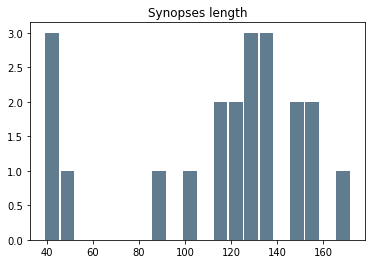

In [114]:
# Generate data on commute times.



plt.hist(len_summary, bins=20, rwidth=0.9,color='#607c8e')
plt.title('Synopses length')
plt.show()
#plt.xlabel('episodes')
#plt.ylabel('Length summary')
#plt.grid(axis='y', alpha=0.75)


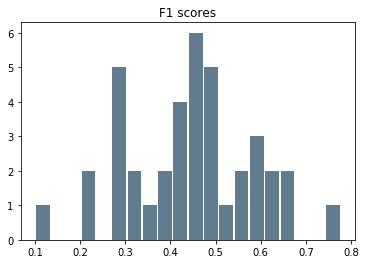

In [27]:
plt.hist(f1_scores, bins=20, rwidth=0.9,color='#607c8e')
plt.title('F1 scores')
plt.show()

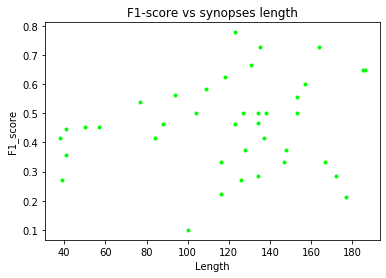

In [36]:




import matplotlib.pyplot as plt

plt.plot(len_summary,f1_scores,linestyle = 'none', marker = 'o', c = 'lime',
  markersize = 3)

plt.title('F1-score vs synopses length')
plt.xlabel('Length')
plt.ylabel('F1_score')
plt.show()

NameError: name 'f1_scores_two_stories' is not defined

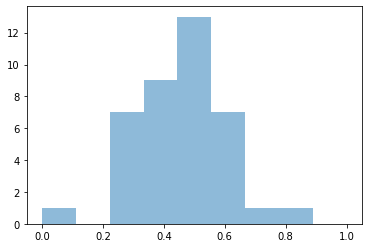

In [37]:
two_stories=['s01e08','s01e13', 's01e20','s02e06','s03e03','s03e05','s03e12','s03e19','s03e21','s04e05','s04e21', 's05e05','s05e10', 's05e12', 's05e17', 's02e04' ,'s03e11', 's04e09', 
's03e11','s04e09']
one_story=list(set(eps)-set(two_stories))


bins = np.linspace(0, 1, 10)

plt.hist(f1_scores_one_story, bins, alpha=0.5, label='one_plot')
plt.hist(f1_scores_two_stories, bins, alpha=0.5, label='two_plots')
plt.legend(loc='upper right')
plt.show()


In [70]:
#eps=['s05e10']
for ep in eps:
    print(ep)
    df=pd.read_csv(ep+'_tfidf_similarity.csv')
    print(df)

s05e10
    Unnamed: 0  scene_id                                         scene_text  \
0            0         0  [' ( Brass and Sofia stand around a dead body ...   
1            1         1  [' ( Sara walks up to David Phillips and Greg ...   
2            2         2  [' ( The door buzzes and opens for Warrick and...   
3            3         3  [' ( The prisoners are lined up in a row . )',...   
4            4         4  [" ( Catherine is standing next to the victim ...   
5            5         5  [' ( The lid is removed from the rubber bin Sa...   
6            6         6  [' ( Robbins goes over his findings with Sara ...   
7            7         7  [' ( Warrick and Det Vartann talk with Lt . )'...   
8            8         8  [' ( Sara is going through stacks of files . )...   
9            9         9  [' ( Warrick pushes the cart full of bagged ev...   
10          10        10  [' ( Sara and Robbins are scanning x-rays into...   
11          11        11  [' ( Sara and Brass

    Unnamed: 0  scene_id                                         scene_text  \
0            0         0  [' ( LINDA JONES is driving her car . )', ' ( ...   
1            1         1  [' ( The TRUCK DRIVER talks with the OFFICER ....   
2            2         2  [' ( CATHERINE reaches out and removes the mas...   
3            3         3  [" ( There 's a man dead on the floor of a fre...   
4            4         4  [' ( NICK and SARA step outside to join DET SA...   
5            5         5  [' ( DAVID PHILLIPS escorts CATHERINE and GRIS...   
6            6         6  [' ( ROBBINS is standing over the body )', ' [...   
7            7         7  [' ( CATHERINE enters the lab . )', ' ( WARRIC...   
8            8         8  [' ( The door opens ; BRASS walks into the roo...   
9            9         9  [" ( It 's the Plushies and Furries PAF CON go...   
10          10        10  [' ( RICH leads SARA and NICK back to the BALL...   
11          11        11  [' ( SARA and NICK are in 

In [ ]:
df_asp=pd.DataFrame(columns=['ep', 'asp_sum', 'asp_nosum', 'noasp_sum', 'nb_in_sum','nb_aspect'])
for ep in eps:
    df=pd.read_csv(ep+'_'+method_used[0]+'_similarity.csv')  
    in_summary=df.loc[df['in_summary'] == 1]
    asp=df.loc[df['aspect?'] == 1]
    asp_sum=df.loc[(df['aspect?'] == 1) & (df['in_summary'] == 1)]
    asp_nosum=df.loc[(df['aspect?'] == 1) & (df['in_summary'] == 0)]
    noasp_sum=df.loc[(df['aspect?'] == 0) & (df['in_summary'] == 1)]
    episode= pd.DataFrame(data= {'ep': [ep], 'asp_sum': [len(asp_sum)], 'asp_nosum': [len(asp_nosum)], 'noasp_sum':[len(noasp_sum)],'nb_in_sum':[len(in_summary)],'nb_aspect':[len(asp)]})
    #print(episode)
    df_asp=df_asp.append(episode,ignore_index=True)

df_asp.loc['Total']= df_asp.sum()  
df_asp['ep']['Total']=''
print(df_asp)

In [433]:
aspects =['Crime scene', 'Victim', 'Death cause', 'Perpetrator', 'Evidence', 'Motive']
#aspects =['Crime scene']

for aspect in aspects:
    df_aspect=pd.DataFrame(columns=['scene_id', 'scene_text', 'in_summary', 'aspects',
       'prediction','ep','aspect_mentionned'])
    for ep in eps:
        df=pd.read_csv(ep+'_'+method_used[0]+'_similarity.csv')
        match=df[['scene_id', 'scene_text', 'in_summary', 'aspects',
       'prediction']][df.isin([aspect]).aspects]
        #print(match)
        match['ep']=ep
        #match['aspect_mentionned']=match.scene_text.apply(lambda lst: 1 if x for x in lst in aspect.lower() else 0 )
        #match['aspect_mentionned']=match.scene_text.apply(lambda x: 1 if x.contains(aspect.lower()) else 0 )
        #any(aspect.lower() in x for x in lst)
        #match['aspect_mentionned']=match[['aspects']][match.scene_text.str.contains('Camera')]='True'
        match['aspect_mentionned']= np.where(match.scene_text.str.contains(aspect.lower()), 1, 0)
        
        
        
        df_aspect=df_aspect.append(match,ignore_index=True)
        
    #df_aspect.to_csv(aspect+'.csv')
    #print(df_aspect.ep[4])
    #print(df_aspect.scene_text[4])
    #print(df_aspect.in_summary[4])
    print(aspect)
    print(df_aspect['aspect_mentionned'].value_counts())
    #print(df_aspect['scene_text'])
    #print('Recall',recall_score(df_aspect.in_summary.astype(int), df_aspect.prediction.astype(int)))
    #print('Precision',precision_score(df_aspect.in_summary.astype(int), df_aspect.prediction.astype(int)))
    #print('-----------------------------------------------------------')

        


Crime scene
0    22
1     5
Name: aspect_mentionned, dtype: int64
Victim
0    26
1     9
Name: aspect_mentionned, dtype: int64
Death cause
0    32
Name: aspect_mentionned, dtype: int64
Perpetrator
0    57
1     1
Name: aspect_mentionned, dtype: int64
Evidence
0    153
1     25
Name: aspect_mentionned, dtype: int64
Motive
0    42
1     3
Name: aspect_mentionned, dtype: int64


In [54]:
for ep in eps:
    df=pd.read_csv(ep+'_'+method_used[0]+'_similarity.csv')
    print(df)

970


In [55]:
word_count

Counter({'camera': 24,
         'open': 17,
         'collin': 39,
         'mail': 2,
         'box': 3,
         'sprinkler': 3,
         'push': 5,
         'slowli': 1,
         'bunni': 2,
         'lawn': 5,
         'decor': 2,
         'near': 2,
         'shut': 3,
         'moment': 3,
         'door': 26,
         'woman': 12,
         'scream': 3,
         'tinacollin': 46,
         'help': 10,
         'tina': 37,
         'run': 8,
         'hous': 26,
         'oh': 6,
         'god': 3,
         'somebodi': 6,
         'street': 1,
         'lung': 1,
         'neighbor': 5,
         's': 122,
         'light': 9,
         'have': 2,
         'turn': 26,
         'reach': 10,
         'start': 13,
         'pound': 1,
         'emerg': 1,
         'vehicl': 3,
         'offic': 9,
         'car': 9,
         'surround': 1,
         'grissom': 298,
         'drive': 1,
         'scene': 13,
         'dispatch': 2,
         'radio': 1,
         'park': 1,
         'exit':

In [22]:
corpus_tf_idf.shape

(36, 271)

In [56]:
print(len(vectorizer.get_stop_words()))


318


'a, about, above, across, after, afterwards, again, against, all, almost, alone, along, already, also, although, always, am, among, amongst, amoungst, amount, an, and, another, any, anyhow, anyone, anything, anyway, anywhere, are, around, as, at, back, be, became, because, become, becomes, becoming, been, before, beforehand, behind, being, below, beside, besides, between, beyond, bill, both, bottom, but, by, call, can, cannot, cant, co, con, could, couldnt, cry, de, describe, detail, do, done, down, due, during, each, eg, eight, either, eleven, else, elsewhere, empty, enough, etc, even, ever, every, everyone, everything, everywhere, except, few, fifteen, fifty, fill, find, fire, first, five, for, former, formerly, forty, found, four, from, front, full, further, get, give, go, had, has, hasnt, have, he, hence, her, here, hereafter, hereby, herein, hereupon, hers, herself, him, himself, his, how, however, hundred, i, ie, if, in, inc, indeed, interest, into, is, it, its, itself, keep, las

In [58]:
tfidf_weights['camera']

2.466337068793427

In [59]:
tfidf_weights['man']

3.5649493574615367

In [60]:
tfidf_weights['hallway']

2.3121863889661687

In [135]:

#summaries_raw = [' '.join(w[1:] if w[0] in ['@', '#', '~'] else w for w in s.split(' ')) for s in summaries_raw]


 gil grissom entir team suspect bizarr cult murder evid tell disturb stori discov motiv massacr


In [43]:
compute_similarity('No more excus . a woman is talk to a man and he is smile TV : ryan stacey',
                   'kat persuad stacey and jean to come to R & R with kat and kim , leav charli and alfi to look after lili',
                    method=('tfidf', tfidf_weights)), compute_similarity('No more excus . a woman is talk to a man and he is smile TV : ryan stacey',
                   'kat persuad stacey and jean to come to R & R with kat and kim , leav charli and alfi to look after lili',
                    method=('count',))

(0, 3)

In [232]:
tfidf_weights['stacey']

3.337750494112952


CPU times: user 102 ms, sys: 3.63 ms, total: 105 ms
Wall time: 101 ms


In [68]:
print(len(summaries))
print(len(corpus))

41
51


In [71]:
best_matches_count[0]

(10.0, 43, 37)

In [106]:
for v, i, j in best_matches_count[:40]:
    print(i, df['content'].iloc[i])
    print("======================")
    #print(summaries_raw[j])
    #print("======================")
    #print(v)
    #print("======================")
    #print(list(w for w in set(summaries[j].split()) if w in corpus[i].split()))

43 [' ( In the garage , CATHERINE speaks into a tape recorder as she takes her notes . )', ' ( She looks at a schematic of the crime scene , # XR-0048-096822-003 . )', ' ( As she speaks , the camera follows on the map . )', " ( It starts with the figure of the father in the hallway in front of BRENDA 'S bedroom door ... )", ' [[Catherine]] notes on mapping : collins family murder', ' [[Catherine]] case # 00-398', ' [[Catherine]] intruder killed mother', ' ( ... then moves to the photo of the mother in the bedroom , Case # 00-398 , Photo # 17 . )', ' [[Catherine]] father went to protect the little girl', ' [[Catherine]] got nicked by knife', " ( Camera moves from the boy 's room on the map to the photo , Case # 00-398 , Photo # 47 . )", " [[Catherine]] killer subdued him as dad was entering the little girl 's room to", ' [[Catherine]] ... save her', " ( Something does n't click . )", " ( It does n't match the photos she 's looking at . )", ' ( She looks at the photo of the blood drops f

In [237]:
# similarity_matrix_tfidf = similarity_matrix

In [74]:
%%time
similarity_matrix_tfidf = np.zeros((len(df), len(summaries)))
for i, content in tqdm(enumerate(corpus), total=len(corpus)):
    for j, s in enumerate(summaries):
        similarity_matrix_tfidf[i, j] = compute_similarity(content, s, method=('tfidf_log_2', tfidf_weights))


CPU times: user 158 ms, sys: 248 µs, total: 158 ms
Wall time: 154 ms


In [75]:
np.max(similarity_matrix_tfidf)

5.073879393072383

In [76]:
similarity_matrix_tfidf.shape

(51, 41)

In [77]:
unrolled_sm = [(similarity_matrix_tfidf[i, j], i, j) for i in range(len(corpus)) for j in range(len(summaries))]
best_matches = sorted(unrolled_sm, key=lambda x: -x[0])

In [78]:
best_matches[:10]

[(5.073879393072383, 18, 11),
 (4.478210112207396, 30, 20),
 (4.4170448331849865, 34, 25),
 (4.086215946851232, 43, 38),
 (4.007664596229994, 43, 22),
 (3.752180905484431, 43, 37),
 (3.674869350872889, 18, 36),
 (3.6345832008706274, 43, 8),
 (3.419196111273055, 45, 37),
 (3.2263587192807943, 36, 27)]

In [375]:
for v, i, j in best_matches[:2]:
    print(i, df['content'].iloc[i])
    print("======================")
    #print(j, summaries_raw[j])
    print("======================")
    print()

KeyError: 'content'

# Making the cut

In [107]:
best_matches[:14]

[(5.073879393072383, 18, 11),
 (4.478210112207396, 30, 20),
 (4.4170448331849865, 34, 25),
 (4.086215946851232, 43, 38),
 (4.007664596229994, 43, 22),
 (3.752180905484431, 43, 37),
 (3.674869350872889, 18, 36),
 (3.6345832008706274, 43, 8),
 (3.419196111273055, 45, 37),
 (3.2263587192807943, 36, 27),
 (3.210115640509777, 16, 17),
 (3.143633682177115, 20, 12),
 (3.0970852254979633, 45, 38),
 (3.0310356319625127, 47, 36)]

[18, 30, 34, 43, 45, 36, 16, 20, 47, 12, 14, 17, 15, 33]

In [128]:

annotated_scenes

,scene_id,scene_text,in_summary,aspects,prediction
0,0,"["" ( Camera opens on the front of the Collins ...",1,Perpetrator,0
1,1,[' ( Emergency vehicles and Officer cars surro...,0,None,0
2,2,[' ( GRISSOM and SHIBLEY walk toward the open ...,0,None,0
3,3,"[' ( GRISSOM and SHIBELY walk inside . )', ' (...",1,Crime scene,0
4,4,[' ( The first thing they see down the hallway...,1,"Victim,Death cause",0
5,5,[' ( GRISSOM and SARA walk into the Master Bed...,1,"Victim,Death cause",0
6,6,[' ( SARA takes a picture of the dead woman . ...,1,Victim,0
7,7,"[' ( GRISSOM walks out of the house . )', "" ( ...",0,None,0
8,8,[' ( A reporter standing outside the house giv...,0,None,0
9,9,"["" ( GRISSOM walks up to DET O'RILEY who is ta...",0,None,0


In [129]:

f1_score(annotated_scenes.in_summary, annotated_scenes.prediction)

0.2857142857142857

In [252]:
votes_selection = {c:[] for c in ['Janine', 'Ryan', 'Stacey']}
votes_durations = {c:[] for c in ['Janine', 'Ryan', 'Stacey']}

for char in votes_selection:
    print(char.upper() + ' =====>')
    counter = 1
    for s in reses:
        if char in df['content'].iloc[s[0]]:
            print(df['content'].iloc[s[0]])
            votes_selection[char].append(df['sid'].iloc[s[0]])
            votes_durations[char].append(df['end'].iloc[s[0]] - df['begin'].iloc[s[0]])
        if len(votes_selection[char]) == 20: 
            break

JANINE =====>
Janine let you out then?  She doesn't own me. Good. I'm going down the Town Hall to  get Lily's birth certificate changed. Why today?  Cos I'm working after. Come on, you, me and Lily. It'll be fun.  All right?   Ryan Stacey
# Nothing more, nothing less  Love is the best... # You all right?  I know. Archie Mitchell's killer. I've  worked it out. Your precious Stacey.   Ryan Janine Stacey
Any time you need me, you know  where I am. Please, Janine. Please?  You've dropped your bombshell,  Pat, why don't you just fly off to New Zealand and enjoy  yourself with your real family. I don't know why I bother  caring about you.   Ryan Janine
I know you want nice little neat  answers. Life's not like that. Don't patronise me.  I'm not a kid any more. Then you should know you can't go  jumping to conclusions and calling it the truth cos that's  what you want to hear. Swear on my life  that it wasn't Stacey. I swear...  on your life...  that Stacey never killed  Archie Mitchell.   Ja

In [256]:
top_selection = {c:[] for c in ['Janine', 'Ryan', 'Stacey']}
top_durations = {c:[] for c in ['Janine', 'Ryan', 'Stacey']}
top_times     = {c:[] for c in ['Janine', 'Ryan', 'Stacey']}

for char in top_selection:
    print(char.upper() + ' =====>')
    counter = 1
    seen = set()
    for (v, s, l) in best_matches:
        if s not in seen and char in df['content'].iloc[s] + df['chars_query'].iloc[s]:
            sentence = df['transcript'].iloc[s].strip()
            print(sentence)
            
            top_selection[char].append(df['sid'].iloc[s])
            top_durations[char].append(round(df['end'].iloc[s] - df['begin'].iloc[s], 2))
            top_times[char].append((df['begin'].iloc[s], df['end'].iloc[s]))

            seen.add(s)
            while sentence and sentence[-1] not in ['.', '?', '!', "'"]:
                s += 1
                sentence = df['transcript'].iloc[s].strip()
                if sentence == '':
                    break
                print(' ++++ ', sentence)

                top_selection[char].append(df['sid'].iloc[s])
                top_durations[char].append(round(df['end'].iloc[s] - df['begin'].iloc[s], 2))
                top_times[char].append((df['begin'].iloc[s], df['end'].iloc[s]))
                seen.add(s)
                counter +=1
                
            counter += 1
        
        if len(seen) >= 20: 
            break

JANINE =====>
Janine let you out then?  She doesn't own me. Good. I'm going down the Town Hall to  get Lily's birth certificate changed. Why today?  Cos I'm working after. Come on, you, me and Lily. It'll be fun.  All right?
# Nothing more, nothing less  Love is the best... # You all right?  I know. Archie Mitchell's killer. I've  worked it out. Your precious Stacey.
Any time you need me, you know  where I am. Please, Janine. Please?  You've dropped your bombshell,  Pat, why don't you just fly off to New Zealand and enjoy  yourself with your real family. I don't know why I bother  caring about you.
I know you want nice little neat  answers. Life's not like that. Don't patronise me.  I'm not a kid any more. Then you should know you can't go  jumping to conclusions and calling it the truth cos that's  what you want to hear. Swear on my life  that it wasn't Stacey. I swear...  on your life...  that Stacey never killed  Archie Mitchell.
Look, whoever finds  the best Christmas present wins.

In [297]:
for char in top_selection:
    print(char.upper())
    for run in range(1, 5):
        print('Run', run, ':', ' '.join(sorted(top_selection[char][:5*run])))

JANINE
Run 1 : 176-1200 177-2024 178-51 182-14 182-1681
Run 2 : 176-1200 176-1785 176-2060 177-2024 178-51 181-116 182-14 182-1494 182-1681 183-1411
Run 3 : 175-2247 176-1200 176-1785 176-2060 177-2024 178-51 181-116 181-1544 182-1108 182-14 182-1494 182-1681 182-676 183-1411 185-992
Run 4 : 175-2247 176-1200 176-1785 176-2060 176-928 177-2024 178-51 181-116 181-1544 182-1108 182-14 182-1494 182-1681 182-676 183-1397 183-1411 183-1883 184-39 185-943 185-992
RYAN
Run 1 : 175-1772 176-1200 177-2024 178-1549 182-1681
Run 2 : 175-1772 176-1092 176-1200 177-2024 178-1549 179-1741 182-1203 182-1681 183-1411 185-438
Run 3 : 175-1772 176-1092 176-1200 176-2060 177-2024 178-1549 179-1741 179-940 181-1084 181-116 182-1203 182-1494 182-1681 183-1411 185-438
Run 4 : 175-1772 175-2247 176-1092 176-1200 176-1242 176-2060 177-2024 178-1549 179-1741 179-940 181-1084 181-116 181-1250 181-1544 182-1203 182-1279 182-1494 182-1681 183-1411 185-438
STACEY
Run 1 : 175-941 176-1200 177-2024 178-1549 185-316


In [298]:
for char in top_durations:
    print(char.upper())
    for run in range(1, 5):
        print('Run', run, ':', sum(top_durations[char][:5*run]))

JANINE
Run 1 : 70.37
Run 2 : 110.13000000000001
Run 3 : 128.97
Run 4 : 174.03
RYAN
Run 1 : 64.69
Run 2 : 121.7
Run 3 : 166.69
Run 4 : 198.14000000000001
STACEY
Run 1 : 52.66
Run 2 : 83.72999999999999
Run 3 : 126.74
Run 4 : 158.09999999999997


In [259]:
for char in votes_durations:
    print(char.upper())
    for run in range(1, 5):
        print('Run', run, ':', sum(votes_durations[char][:5*run]))

JANINE
Run 1 : 70.37000000000016
Run 2 : 110.1300000000018
Run 3 : 128.97000000000287
Run 4 : 174.03000000000267
RYAN
Run 1 : 64.69000000000051
Run 2 : 121.70000000000073
Run 3 : 166.69000000000148
Run 4 : 198.1400000000022
STACEY
Run 1 : 52.660000000000196
Run 2 : 93.0399999999998
Run 3 : 139.8
Run 4 : 162.10000000000065


In [291]:
top_times

{'Janine': [(3904.24, 3917.08),
  (7070.01, 7088.24),
  (5542.12, 5558.14),
  (238.06, 258.23),
  (37.09, 40.2),
  (4743.24, 4747.24),
  (5791.23, 5796.1),
  (4854.11, 4867.08),
  (347.02, 348.08),
  (6681.23, 6698.09),
  (6703.17, 6709.13),
  (5130.19, 5132.1),
  (2986.18, 2989.0),
  (2101.16, 2106.21),
  (3491.02, 3494.12),
  (2861.11, 2867.01),
  (6411.17, 6417.17),
  (4668.06, 4688.21),
  (2883.13, 2886.05),
  (138.01, 148.1)],
 'Ryan': [(3904.24, 3917.08),
  (7070.01, 7088.24),
  (5326.22, 5328.05),
  (5167.23, 5183.0),
  (5542.12, 5558.14),
  (3545.24, 3565.09),
  (1333.04, 1345.19),
  (5856.08, 5864.03),
  (3807.08, 3820.14),
  (4743.24, 4747.24),
  (3746.02, 3749.06),
  (4854.11, 4867.08),
  (3070.13, 3081.19),
  (347.02, 348.08),
  (6681.23, 6698.09),
  (4212.14, 4228.04),
  (6703.17, 6709.13),
  (4064.21, 4067.01),
  (4068.14, 4073.02),
  (5130.19, 5132.1)],
 'Stacey': [(2688.13, 2691.01),
  (3904.24, 3917.08),
  (883.21, 886.15),
  (7070.01, 7088.24),
  (5167.23, 5183.0),
  

In [261]:
pickle.dump(top_selection, open('selected_shots_final.pickle', 'wb'))
pickle.dump(top_times, open('selected_shots_boundaries_final.pickle', 'wb'))

# Generate the Videos!

In [281]:
! pip install -q moviepy

In [299]:
shot_boundaries = {}
for character in top_selection:
    for shot in top_selection[character]:
        if shot not in shot_boundaries:
            shot_boundaries[shot] = mastershot_df[mastershot_df.sid == shot][['start', 'end']].values[0]

In [300]:
set([k.split('-')[0] for k in shot_boundaries])

{'175', '176', '177', '178', '179', '181', '182', '183', '184', '185'}

In [301]:
shot_boundaries.keys()

dict_keys(['176-1200', '177-2024', '182-1681', '178-51', '182-14', '183-1411', '176-1785', '182-1494', '181-116', '176-2060', '175-2247', '181-1544', '185-992', '182-676', '182-1108', '176-928', '183-1883', '183-1397', '185-943', '184-39', '175-1772', '178-1549', '176-1092', '185-438', '179-1741', '182-1203', '181-1084', '179-940', '181-1250', '176-1242', '182-1279', '175-941', '185-316', '185-981', '184-2212', '184-2213', '182-1509', '182-1188', '177-1793', '182-57', '184-1785'])

In [ ]:
shot185_1736

In [284]:
3763.13 * 25

94078.25

In [285]:
os.listdir('../../eastenders_episodes')

['5531550228324592939.mp4',
 '5534228999422914578.mp4',
 '5542003749222140011.mp4',
 '5555325449284154780.mp4',
 '5547193787702629969.mp4',
 '5544620672795594434.mp4',
 '5555360238519252381.mp4',
 '5552368364300855101.mp4',
 '5549784941472309008.mp4',
 '5544574287152993687.mp4',
 '5539381671692122744.mp4']

In [286]:
"""%%time
frames = {}
# Read until video is completed
for filename in tqdm(os.listdir('../../eastenders_episodes'), total=11):
    print('Processing', filename)
    vid = cv2.VideoCapture('../../eastenders_episodes/' + filename)
    vid_id = file2id[filename]
    current_frame = 0
    
    for sid in sorted([sid for sid in shot_boundaries if sid.startswith(vid_id)]):
        start_frame = int(shot_boundaries[shot][0] * 25)
        end_frame = int(shot_boundaries[shot][1] * 25)
        frames[sid] = []
        
        while(cap.isOpened()):
            ret, frame = cap.read()
            current_frame += 1
            if ret == True and current_frame >= start_frame and current_frame <= end_frame:
                frames[sid].append(frame)
            if ret == True and current_frame > end_frame:
                print(f'frames[{sid}]:', len(frames[sid]))
                break

    vid.release()"""
print('Using OpenCV is too slow')

Using OpenCV is too slow


In [287]:
df[df.sid == '175-1772'][['begin', 'end']].values[0]

array([5326.22, 5328.05])

In [303]:
%%time
frames = {}
durs = {}
# Read until video is completed
for filename in tqdm(os.listdir('../../eastenders_episodes'), total=11):
    print('Processing', filename)
    video = VideoFileClip('../../eastenders_episodes/' + filename)
    vid_id = file2id[filename]
    current_frame = 0
    
    for sid in sorted([sid for sid in shot_boundaries if sid.startswith(vid_id)]):
        try:
            start, end = shot_boundaries[sid]
            frames[sid] = video.subclip(start, end)
            durs[sid] = (strptime(end, '%H:%M:%S.%f') - strptime(start, '%H:%M:%S.%f')).total_seconds()
        except Exception as e:
            print('EXCEPTION', str(e))
            print(sid, start, end)

Processing 5531550228324592939.mp4
Processing 5534228999422914578.mp4
Processing 5542003749222140011.mp4
Processing 5555325449284154780.mp4
Processing 5547193787702629969.mp4
Processing 5544620672795594434.mp4
Processing 5555360238519252381.mp4
Processing 5552368364300855101.mp4
Processing 5549784941472309008.mp4
Processing 5544574287152993687.mp4
Processing 5539381671692122744.mp4

CPU times: user 130 ms, sys: 4.15 s, total: 4.28 s
Wall time: 18.2 s


In [304]:
for char in top_selection:
    print(char.upper())
    print('Generating videos for', char, ':')
    for run in range(1, 5):
        t = time.time()
        print('   Run', run, '..', end=' ')
        shots = sorted(top_selection[char][:5*run])
        result = concatenate_videoclips([frames[sid] for sid in shots]) 
        result.write_videofile(f"videos/MeMAD_{run}_{char}.mp4",fps=25, logger=None)
        print(f'Done! ({(time.time() - t):.2f} s)')

JANINE
Generating videos for Janine :
   Run 1 .. Done! (20.18 s)
   Run 2 .. Done! (37.67 s)
   Run 3 .. Done! (45.12 s)
   Run 4 .. Done! (58.39 s)
RYAN
Generating videos for Ryan :
   Run 1 .. Done! (20.10 s)
   Run 2 .. Done! (37.25 s)
   Run 3 .. Done! (53.85 s)
   Run 4 .. Done! (68.36 s)
STACEY
Generating videos for Stacey :
   Run 1 .. Done! (20.21 s)
   Run 2 .. Done! (28.77 s)
   Run 3 .. Done! (44.57 s)
   Run 4 .. Done! (59.39 s)


In [351]:
results = {'Janine': {1:[('175_1', 5.3), ('175_2', 5.3)],
                      2:[('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3)],
                      3:[('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3), ('175_4', 5.3)],
                      4:[('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3), ('175_4', 5.3), ('175_5', 5.3)],},
           'Ryan':   {1:[('175_1', 5.3), ('175_2', 5.3)],
                      2:[('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3)],
                      3:[('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3), ('175_4', 5.3)],
                      4:[('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3), ('175_4', 5.3), ('175_5', 5.3)],},
           'Stacey': {1:[('175_1', 5.3), ('175_2', 5.3)],
                      2:[('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3)],
                      3:[('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3), ('175_4', 5.3)],
                      4:[('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3), ('175_4', 5.3), ('175_5', 5.3)],}}

In [354]:
results

{'Janine': {1: [('175_1', 5.3), ('175_2', 5.3)],
  2: [('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3)],
  3: [('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3), ('175_4', 5.3)],
  4: [('175_1', 5.3),
   ('175_2', 5.3),
   ('175_3', 5.3),
   ('175_4', 5.3),
   ('175_5', 5.3)]},
 'Ryan': {1: [('175_1', 5.3), ('175_2', 5.3)],
  2: [('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3)],
  3: [('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3), ('175_4', 5.3)],
  4: [('175_1', 5.3),
   ('175_2', 5.3),
   ('175_3', 5.3),
   ('175_4', 5.3),
   ('175_5', 5.3)]},
 'Stacey': {1: [('175_1', 5.3), ('175_2', 5.3)],
  2: [('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3)],
  3: [('175_1', 5.3), ('175_2', 5.3), ('175_3', 5.3), ('175_4', 5.3)],
  4: [('175_1', 5.3),
   ('175_2', 5.3),
   ('175_3', 5.3),
   ('175_4', 5.3),
   ('175_5', 5.3)]}}

In [367]:
results = {}
for char in top_selection:
    results[char] = {}
    for run in range(1, 5):
        shots = sorted(top_selection[char][:5*run])
        results[char][run] = [(shot.replace('-', '_'), durs[shot]) for shot in shots] # [('100-1', 10.5) for shot in shots] #

In [368]:
results

{'Janine': {1: [('176_1200', 12.84),
   ('177_2024', 18.23),
   ('178_51', 20.17),
   ('182_14', 3.11),
   ('182_1681', 16.02)],
  2: [('176_1200', 12.84),
   ('176_1785', 4.87),
   ('176_2060', 16.86),
   ('177_2024', 18.23),
   ('178_51', 20.17),
   ('181_116', 1.06),
   ('182_14', 3.11),
   ('182_1494', 12.97),
   ('182_1681', 16.02),
   ('183_1411', 4.0)],
  3: [('175_2247', 5.96),
   ('176_1200', 12.84),
   ('176_1785', 4.87),
   ('176_2060', 16.86),
   ('177_2024', 18.23),
   ('178_51', 20.17),
   ('181_116', 1.06),
   ('181_1544', 1.91),
   ('182_1108', 3.1),
   ('182_14', 3.11),
   ('182_1494', 12.97),
   ('182_1681', 16.02),
   ('182_676', 5.05),
   ('183_1411', 4.0),
   ('185_992', 2.82)],
  4: [('175_2247', 5.96),
   ('176_1200', 12.84),
   ('176_1785', 4.87),
   ('176_2060', 16.86),
   ('176_928', 5.9),
   ('177_2024', 18.23),
   ('178_51', 20.17),
   ('181_116', 1.06),
   ('181_1544', 1.91),
   ('182_1108', 3.1),
   ('182_14', 3.11),
   ('182_1494', 12.97),
   ('182_1681',

In [376]:
def generate_results(results):
    team_name = 'MeMAD'
    desc = "The output"
    query_characters = ['Janine', 'Ryan', 'Stacey']
    shots_per_run = {1: 5, 2: 10, 3:15, 4:20}

    for run in [1, 2, 3, 4]:
        with open(f'xml/{team_name}_run_{run}.xml', 'wt') as file:
            file.write('<!DOCTYPE videoSummarizationResults SYSTEM "https://www-nlpir.nist.gov/projects/tv2020/dtds/videoSummarizationResults.dtd">\n')
            file.write('<videoSummarizationResults>\n')
            file.write(f'\t<videoSummarizationRunResult pid="{team_name}" priority="{run}" desc="Run {run}">\n')
            for character in query_characters:
                n_shots = shots_per_run[run]
                duration = sum([c[1] for c in results[character][run]])
                file.write(f'\t\t<videoSummarizationTopicResult  target="{character}" numShots="{shots_per_run[run]}" summTime="{round(duration, 1)}">\n')
                for i, shot_id in enumerate(results[character][run]):
                    file.write(f'\t\t\t<item seqNum="{i+1}" shotId="shot{shot_id[0]}"/>\n')
                file.write(f'\t\t</videoSummarizationTopicResult>\n')
            file.write('\t</videoSummarizationRunResult>\n')
            file.write('</videoSummarizationResults>\n')

In [377]:
generate_results(results)